In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms, models
from tqdm.auto import tqdm
from PIL import Image
from sklearn.metrics import classification_report, balanced_accuracy_score
from torch.amp import autocast, GradScaler

c:\ProgramData\anaconda3\Lib\site-packages\torch\cuda\__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [ ]:
data_path = "datasets"
data = np.load(f"{data_path}/pathmnist_128.npz")

In [4]:
print(data.keys())

KeysView(NpzFile 'datasets/pathmnist_128.npz' with keys: train_images, train_labels, val_images, val_labels, test_images...)


In [6]:
train_images = data['train_images']
train_labels = data['train_labels']

validation_images = data['val_images']
validation_labels = data['val_labels']

test_images = data['test_images']
test_labels = data['test_labels']

In [9]:
print(f"The shape of train images: {train_images.shape}, train labels: {train_labels.shape}")
print(f"The shape of validation images: {validation_images.shape}, validation labels: {validation_labels.shape}")
print(f"The shape of test images: {test_images.shape}, test labels: {test_labels.shape}")

The shape of train images: (89996, 128, 128, 3), train labels: (89996, 1)
The shape of validation images: (10004, 128, 128, 3), validation labels: (10004, 1)
The shape of test images: (7180, 128, 128, 3), test labels: (7180, 1)


In [10]:
import numpy as np

# Count labels per class
unique, counts = np.unique(train_labels, return_counts=True)
print(f"Train - Labels per class: {dict(zip(unique, counts))}")
print(f"Total train samples: {len(train_labels)}")

unique, counts = np.unique(validation_labels, return_counts=True)
print(f"\nVal - Labels per class: {dict(zip(unique, counts))}")
print(f"Total val samples: {len(validation_labels)}")

unique, counts = np.unique(test_labels, return_counts=True)
print(f"\nTest - Labels per class: {dict(zip(unique, counts))}")
print(f"Total test samples: {len(test_labels)}")

# Combined
all_labels = np.concatenate([train_labels, validation_labels, test_labels])
unique, counts = np.unique(all_labels, return_counts=True)
print(f"\nAll - Labels per class: {dict(zip(unique, counts))}")
print(f"Total samples: {len(all_labels)}")

Train - Labels per class: {np.uint8(0): np.int64(9366), np.uint8(1): np.int64(9509), np.uint8(2): np.int64(10360), np.uint8(3): np.int64(10401), np.uint8(4): np.int64(8006), np.uint8(5): np.int64(12182), np.uint8(6): np.int64(7886), np.uint8(7): np.int64(9401), np.uint8(8): np.int64(12885)}
Total train samples: 89996

Val - Labels per class: {np.uint8(0): np.int64(1041), np.uint8(1): np.int64(1057), np.uint8(2): np.int64(1152), np.uint8(3): np.int64(1156), np.uint8(4): np.int64(890), np.uint8(5): np.int64(1354), np.uint8(6): np.int64(877), np.uint8(7): np.int64(1045), np.uint8(8): np.int64(1432)}
Total val samples: 10004

Test - Labels per class: {np.uint8(0): np.int64(1338), np.uint8(1): np.int64(847), np.uint8(2): np.int64(339), np.uint8(3): np.int64(634), np.uint8(4): np.int64(1035), np.uint8(5): np.int64(592), np.uint8(6): np.int64(741), np.uint8(7): np.int64(421), np.uint8(8): np.int64(1233)}
Total test samples: 7180

All - Labels per class: {np.uint8(0): np.int64(11745), np.uint8

In [7]:
import torch
from torch.utils.data import WeightedRandomSampler

# Calculate class weights (inverse frequency)
unique, counts = np.unique(train_labels, return_counts=True)
class_weights = 1.0 / counts
class_weights = class_weights / class_weights.sum() * len(class_weights)  # normalize
class_weights = torch.FloatTensor(class_weights)

print(f"Class weights: {class_weights}")

Class weights: tensor([1.0418, 1.0261, 0.9418, 0.9381, 1.2187, 0.8010, 1.2373, 1.0379, 0.7573])


In [8]:
# Get weight for each sample based on its label
sample_weights = class_weights[train_labels.flatten().astype(int)]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)

In [9]:
class ColonDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self): 
        return len(self.images) # number of samples
    
    def __getitem__(self, idx):
        img = self.images[idx]

        if isinstance(img, np.ndarray):
            img = Image.fromarray(img.astype('uint8'))

        if self.transform: # apply transformations
            img = self.transform(img)

        label = self.labels[idx]
        label = torch.tensor(label, dtype=torch.float)
        
        return img, label

# Calculating the Mean and STD for the Dataset

In [7]:
def calculate_mean_std(dataset):

    loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=0)

    channel_sum = torch.zeros(3)
    channel_sum_sq = torch.zeros(3)
    num_pixels = 0

    # Wrap the loader with tqdm to create a progress bar for monitoring.
    for images, _ in tqdm(loader, desc="Calculating Dataset Stats"):
        # Add the total number of pixels in this batch to the running total.
        num_pixels += images.size(0) * images.size(2) * images.size(3)
        
        # Sum the pixel values across the batch, height, and width dimensions,
        # leaving only the channel dimension. Add this to the running total.
        channel_sum += images.sum(dim=[0, 2, 3])
        
        # Square each pixel value, then sum them up similarly to the step above.
        channel_sum_sq += (images ** 2).sum(dim=[0, 2, 3])

    # Calculate the mean for each channel.
    mean = channel_sum / num_pixels
    # Calculate the standard deviation using the formula: sqrt(E[X^2] - E[X]^2)
    std = (channel_sum_sq / num_pixels - mean ** 2) ** 0.5

    # Return the calculated mean and standard deviation.
    return mean, std

In [ ]:
temp_simple_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])

temp_dataset = ColonDataset(train_images, train_labels, transform=temp_simple_transform)

dataset_mean, dataset_std = calculate_mean_std(temp_dataset)


print(f"Dataset Mean: {dataset_mean}")
print(f"Dataset Std:  {dataset_std}")

Calculating Dataset Stats:   0%|          | 0/1407 [00:00<?, ?it/s]

Dataset Mean: tensor([0.7405, 0.5330, 0.7058])
Dataset Std:  tensor([0.1237, 0.1768, 0.1244])


In [10]:
from torchvision import transforms # to apply transformations to the images

transforms_with_augmentation = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(), # convert to tensor
    transforms.RandomRotation(degrees=15), # Randomly rotates the image between -10 and +10 degrees
    transforms.Normalize((0.7405, 0.5330, 0.7058), (0.1237, 0.1768, 0.1244))
])

transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(), # convert to tensor
    transforms.Normalize((0.7405, 0.5330, 0.7058), (0.1237, 0.1768, 0.1244))
])

In [11]:
train_dataset = ColonDataset(train_images, train_labels, transform=transforms_with_augmentation)
validation_dataset = ColonDataset(validation_images, validation_labels, transform=transforms)
test_dataset = ColonDataset(test_images, test_labels, transform=transforms)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0, pin_memory=False)
validation_loader = DataLoader(validation_dataset, batch_size=1000, shuffle=False, num_workers=0, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=0, pin_memory=False)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [14]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(512, 9)
)
model = model.to(device)
# try:
#     model = torch.compile(model)
# except Exception:
#     print("torch.compile not error")

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scaler = GradScaler(device='cuda')
scheduler = StepLR(optimizer, step_size=4, gamma=0.8)

In [16]:
import time
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score, f1_score

train_f1s = []
val_f1s = []

train_losses = []
train_aucs = []
train_accs = []
val_losses = []
val_aucs = []
val_accs = []
train_epoch_times = []
val_f1_micros = []

import time
from sklearn.metrics import roc_auc_score

epoch = 1

In [19]:
def train_model(number_of_epochs):
    global epoch
    
    for i in range(number_of_epochs):
        model.train()
        total_loss = 0
        all_outputs = []
        all_targets = []
        
        start_time = time.time()

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            targets = targets.squeeze(1).long()  # Change (batch, 1) to (batch,)
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            with autocast(device_type='cuda'):
                outputs = model(inputs)
                loss_value = criterion(outputs, targets)  # Use criterion
            scaler.scale(loss_value).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss_value.item()
            all_outputs.append(torch.softmax(outputs, dim=1).detach().cpu())
            all_targets.append(targets.cpu())

        all_outputs = torch.cat(all_outputs).numpy()
        all_targets = torch.cat(all_targets).numpy()

        print(f"Sum check: {all_outputs[0].sum()}, Shape: {all_outputs.shape}")

        
        avg_loss = total_loss / len(train_loader)
        try:
            all_outputs = all_outputs / all_outputs.sum(axis=1, keepdims=True)
            auc = roc_auc_score(all_targets, all_outputs, average='macro', multi_class='ovr')
        except ValueError:
            auc = 0.0
            print("ROC AUC calculation error, setting AUC to 0.0 for this epoch.")
        train_acc = (all_outputs.argmax(axis=1) == all_targets).mean()
        train_f1 = f1_score(all_targets, all_outputs.argmax(axis=1), average='macro')

        
        train_losses.append(avg_loss)
        train_aucs.append(auc)
        train_accs.append(train_acc)
        train_f1s.append(train_f1) 

        
        epoch_time = time.time() - start_time
        train_epoch_times.append(epoch_time)
        
        scheduler.step()  # Step scheduler after training
        
        # Validation
        model.eval()
        val_total_loss = 0
        val_outputs = []
        val_targets = []

        with torch.no_grad():
            for inputs, targets in validation_loader:
                targets = targets.squeeze(1).long()  # Change (batch, 1) to (batch,)
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss_value = criterion(outputs, targets)  # Use criterion
                val_total_loss += val_loss_value.item()
                val_outputs.append(torch.softmax(outputs, dim=1).cpu())
                val_targets.append(targets.cpu())
        
        val_outputs = torch.cat(val_outputs).numpy()
        val_targets = torch.cat(val_targets).numpy()


        
        val_avg_loss = val_total_loss / len(validation_loader)

        try:
            val_outputs = val_outputs / val_outputs.sum(axis=1, keepdims=True)
            val_auc = roc_auc_score(val_targets, val_outputs, average='macro', multi_class='ovr')
        except ValueError:
            val_auc = 0.0
            print("ROC AUC calculation error, setting AUC to 0.0 for this epoch.")

        val_acc = (val_outputs.argmax(axis=1) == val_targets).mean()
        val_f1 = f1_score(val_targets, val_outputs.argmax(axis=1), average='macro')
        val_f1_micro = f1_score(val_targets, val_outputs.argmax(axis=1), average='micro')
        y_pred = val_outputs.argmax(axis=1)
        y_true = val_targets.astype(int)


        
        val_losses.append(val_avg_loss)
        val_aucs.append(val_auc)
        val_accs.append(val_acc)
        val_f1s.append(val_f1)
        val_f1_micros.append(val_f1_micro)

        if (epoch) >= 3:
            torch.save(model.state_dict(), f"models/model_epoch_{epoch}.pt")
        print(f"----- Epoch {epoch} report -----")
        print(f"Train Loss: {avg_loss:.4f}, Train AUC: {auc:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, Val Loss: {val_avg_loss:.4f}, Val AUC: {val_auc:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}, Val F1 Micro: {val_f1_micro:.4f}, Time: {epoch_time:.2f}s, LR: {optimizer.param_groups[0]['lr']:.6f}")
        print(f"Validation Classification Report:\n{classification_report(y_true, y_pred)}")
        print(f"Balanced validation accuracy: {balanced_accuracy_score(y_true, y_pred)}")

        # Save metrics to file
        with open('statistics/training_metrics.txt', 'a') as f:
            f.write(f"Epoch {epoch}\n")
            f.write(f"Train - Loss: {avg_loss:.4f}, AUC: {auc:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}\n")
            f.write(f"Val - Loss: {val_avg_loss:.4f}, AUC: {val_auc:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, F1 Micro: {val_f1_micro:.4f}\n")
            f.write(f"Balanced Acc: {balanced_accuracy_score(y_true, y_pred):.4f}, Time: {epoch_time:.2f}s, LR: {optimizer.param_groups[0]['lr']:.6f}\n")
            f.write(f"{classification_report(y_true, y_pred)}\n")
            f.write("-" * 80 + "\n\n")

        epoch += 1

In [18]:
training_epochs = 20
train_model(training_epochs)

Sum check: 1.0, Shape: (89996, 9)
ROC AUC calculation error, setting AUC to 0.0 for this epoch.
----- Epoch 1 report -----
Train Loss: 0.1328, Train AUC: 0.0000, Train Acc: 0.9574, Train F1: 0.9571, Val Loss: 0.0434, Val AUC: 0.9998, Val Acc: 0.9851, Val F1: 0.9852, Val F1 Micro: 0.9851, Time: 137.89s, LR: 0.000100
Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1041
           1       1.00      1.00      1.00      1057
           2       0.98      0.99      0.98      1152
           3       1.00      1.00      1.00      1156
           4       0.98      0.98      0.98       890
           5       0.95      1.00      0.98      1354
           6       0.99      0.98      0.99       877
           7       0.99      0.93      0.96      1045
           8       0.98      0.99      0.99      1432

    accuracy                           0.99     10004
   macro avg       0.99      0.98      0.99     10004

KeyboardInterrupt: 

In [20]:
training_epochs = 3
train_model(training_epochs)

Sum check: 1.0, Shape: (89996, 9)
ROC AUC calculation error, setting AUC to 0.0 for this epoch.
----- Epoch 4 report -----
Train Loss: 0.0214, Train AUC: 0.0000, Train Acc: 0.9932, Train F1: 0.9931, Val Loss: 0.0177, Val AUC: 0.9999, Val Acc: 0.9941, Val F1: 0.9939, Val F1 Micro: 0.9941, Time: 130.11s, LR: 0.000080
Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1041
           1       1.00      1.00      1.00      1057
           2       1.00      0.99      0.99      1152
           3       1.00      1.00      1.00      1156
           4       0.98      0.99      0.98       890
           5       0.99      1.00      1.00      1354
           6       0.99      0.99      0.99       877
           7       1.00      0.99      0.99      1045
           8       0.99      0.99      0.99      1432

    accuracy                           0.99     10004
   macro avg       0.99      0.99      0.99     10004

In [21]:
training_epochs = 10
train_model(training_epochs)

Sum check: 1.0, Shape: (89996, 9)
ROC AUC calculation error, setting AUC to 0.0 for this epoch.
----- Epoch 7 report -----
Train Loss: 0.0109, Train AUC: 0.0000, Train Acc: 0.9963, Train F1: 0.9963, Val Loss: 0.0175, Val AUC: 0.9999, Val Acc: 0.9942, Val F1: 0.9942, Val F1 Micro: 0.9942, Time: 125.28s, LR: 0.000080
Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1041
           1       1.00      1.00      1.00      1057
           2       0.99      0.99      0.99      1152
           3       1.00      1.00      1.00      1156
           4       0.99      0.99      0.99       890
           5       0.99      0.99      0.99      1354
           6       1.00      0.99      0.99       877
           7       0.99      0.99      0.99      1045
           8       0.99      1.00      0.99      1432

    accuracy                           0.99     10004
   macro avg       0.99      0.99      0.99     10004

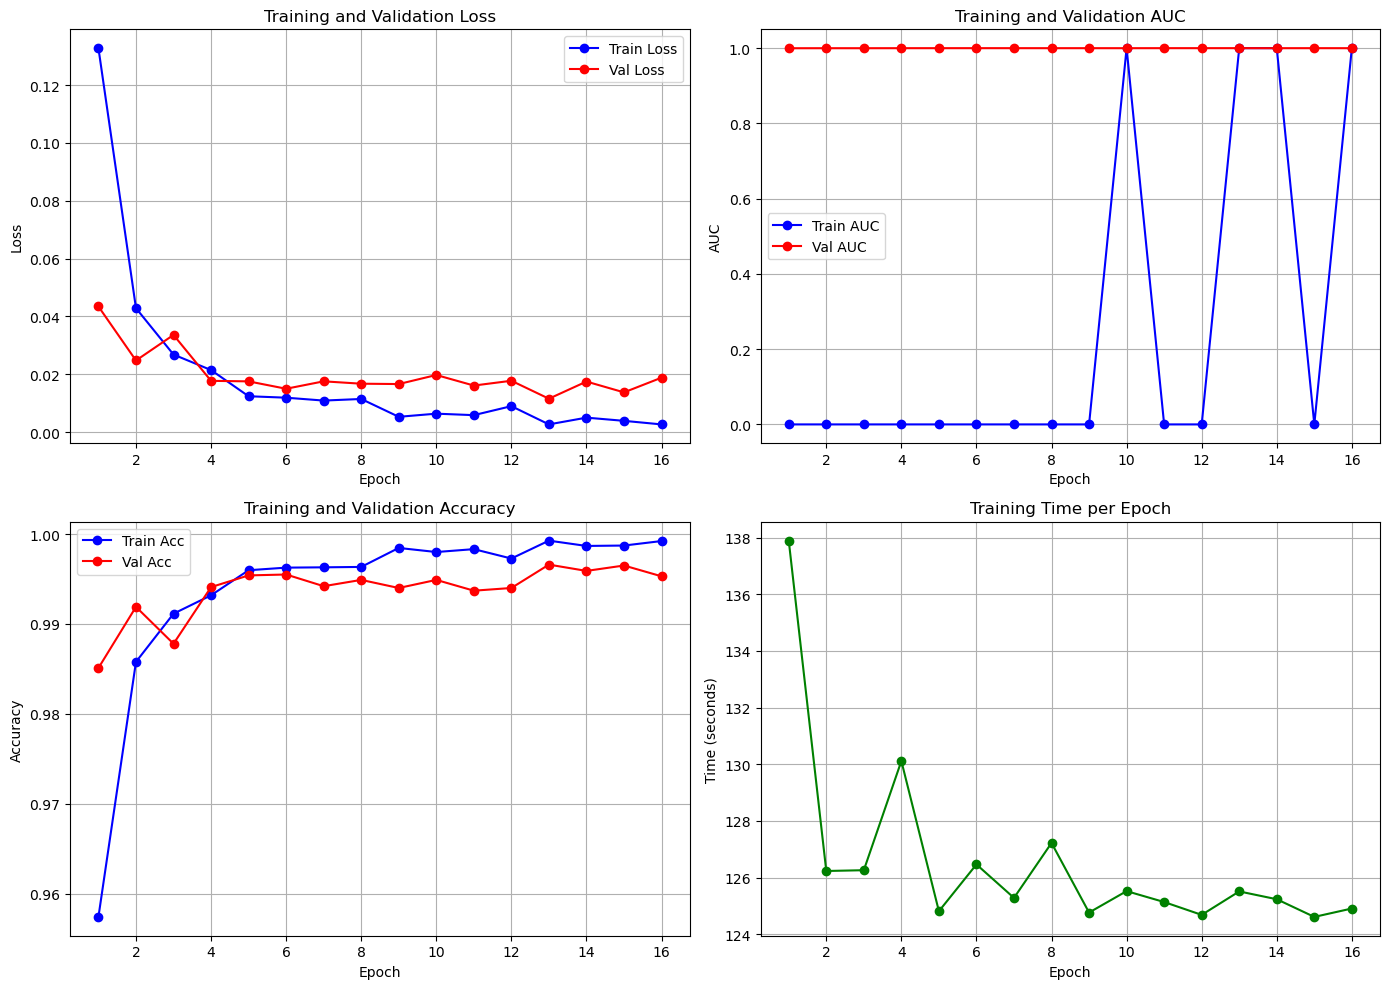

In [22]:
import matplotlib.pyplot as plt
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

epochs = range(1, len(train_losses) + 1)

# Plot 1: Loss
axes[0, 0].plot(epochs, train_losses, 'b-o', label='Train Loss')
axes[0, 0].plot(epochs, val_losses, 'r-o', label='Val Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot 2: AUC
axes[0, 1].plot(epochs, train_aucs, 'b-o', label='Train AUC')
axes[0, 1].plot(epochs, val_aucs, 'r-o', label='Val AUC')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('AUC')
axes[0, 1].set_title('Training and Validation AUC')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot 3: Accuracy
axes[1, 0].plot(epochs, train_accs, 'b-o', label='Train Acc')
axes[1, 0].plot(epochs, val_accs, 'r-o', label='Val Acc')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Training and Validation Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot 4: Epoch Time
axes[1, 1].plot(epochs, train_epoch_times, 'g-o')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Time (seconds)')
axes[1, 1].set_title('Training Time per Epoch')
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('statistics/training_plots.png', dpi=300, bbox_inches='tight')
plt.show()

In [24]:
model.load_state_dict(torch.load('models/model_epoch_13.pt'))

# Test set evaluation
model.eval()
test_outputs = []
test_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        targets = targets.squeeze(1).long()
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        test_outputs.append(torch.softmax(outputs, dim=1).cpu())
        test_targets.append(targets.cpu())

test_outputs = torch.cat(test_outputs).numpy()
test_targets = torch.cat(test_targets).numpy()

# Normalize outputs
test_outputs = test_outputs / test_outputs.sum(axis=1, keepdims=True)

# Calculate metrics
try:
    test_auc = roc_auc_score(test_targets, test_outputs, average='macro', multi_class='ovr')
except ValueError:
    test_auc = 0.0
    print("ROC AUC calculation error, setting AUC to 0.0")

test_acc = (test_outputs.argmax(axis=1) == test_targets).mean()
test_f1 = f1_score(test_targets, test_outputs.argmax(axis=1), average='macro')
test_f1_micro = f1_score(test_targets, test_outputs.argmax(axis=1), average='micro')
test_balanced_acc = balanced_accuracy_score(test_targets, test_outputs.argmax(axis=1))

y_pred = test_outputs.argmax(axis=1)
y_true = test_targets.astype(int)

# Print results
print(f"----- Test Set Results -----")
print(f"Test AUC: {test_auc:.4f}, Test Acc: {test_acc:.4f}, Test F1: {test_f1:.4f}, Test F1 Micro: {test_f1_micro:.4f}")
print(f"Balanced Test Accuracy: {test_balanced_acc:.4f}")
print(f"Test Classification Report:\n{classification_report(y_true, y_pred)}")

# Save to file
with open('statistics/test_metrics.txt', 'w') as f:
    f.write(f"Test Set Results\n")
    f.write(f"AUC: {test_auc:.4f}, Acc: {test_acc:.4f}, F1: {test_f1:.4f}, F1 Micro: {test_f1_micro:.4f}\n")
    f.write(f"Balanced Acc: {test_balanced_acc:.4f}\n")
    f.write(f"{classification_report(y_true, y_pred)}\n")

C:\Users\mamou\AppData\Local\Temp\ipykernel_21640\2992470767.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/model_epoch_13.pt')

----- Test Set Results -----
Test AUC: 0.9945, Test Acc: 0.9311, Test F1: 0.9080, Test F1 Micro: 0.9311
Balanced Test Accuracy: 0.9148
Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1338
           1       0.94      1.00      0.97       847
           2       0.75      0.97      0.85       339
           3       0.95      0.91      0.93       634
           4       0.97      0.96      0.96      1035
           5       0.76      0.85      0.80       592
           6       0.95      0.98      0.96       741
           7       0.90      0.67      0.77       421
           8       0.98      0.95      0.96      1233

    accuracy                           0.93      7180
   macro avg       0.91      0.91      0.91      7180
weighted avg       0.94      0.93      0.93      7180

